# Homework 12
## Time Series Analysis
### Ali Asghar Yousuf
### ay06993@st.habib.edu.pk

In [119]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import warnings
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression

In [105]:
# warnings.filterwarnings("ignore")  # optional
# plt.style.use('fivethirtyeight')  # optional
# matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
# matplotlib.rcParams['text.color'] = 'k'

In [106]:
file_name = 'karachi-weather-2021-2023.csv'
df = pd.read_csv(file_name, parse_dates=['datetime'])
df.head()

,datetime,temp
0,2021-01-01,15.0
1,2021-01-02,15.4
2,2021-01-03,15.6
3,2021-01-04,16.3
4,2021-01-05,17.1


In [107]:
df = df.set_index('datetime')
df.head()

,temp
datetime,
2021-01-01,15.0
2021-01-02,15.4
2021-01-03,15.6
2021-01-04,16.3
2021-01-05,17.1


### Q1

Aggregate the data

In [108]:
df = df['temp'].resample('W').mean()

### Q2

Visualize the trend and seasonality in the data

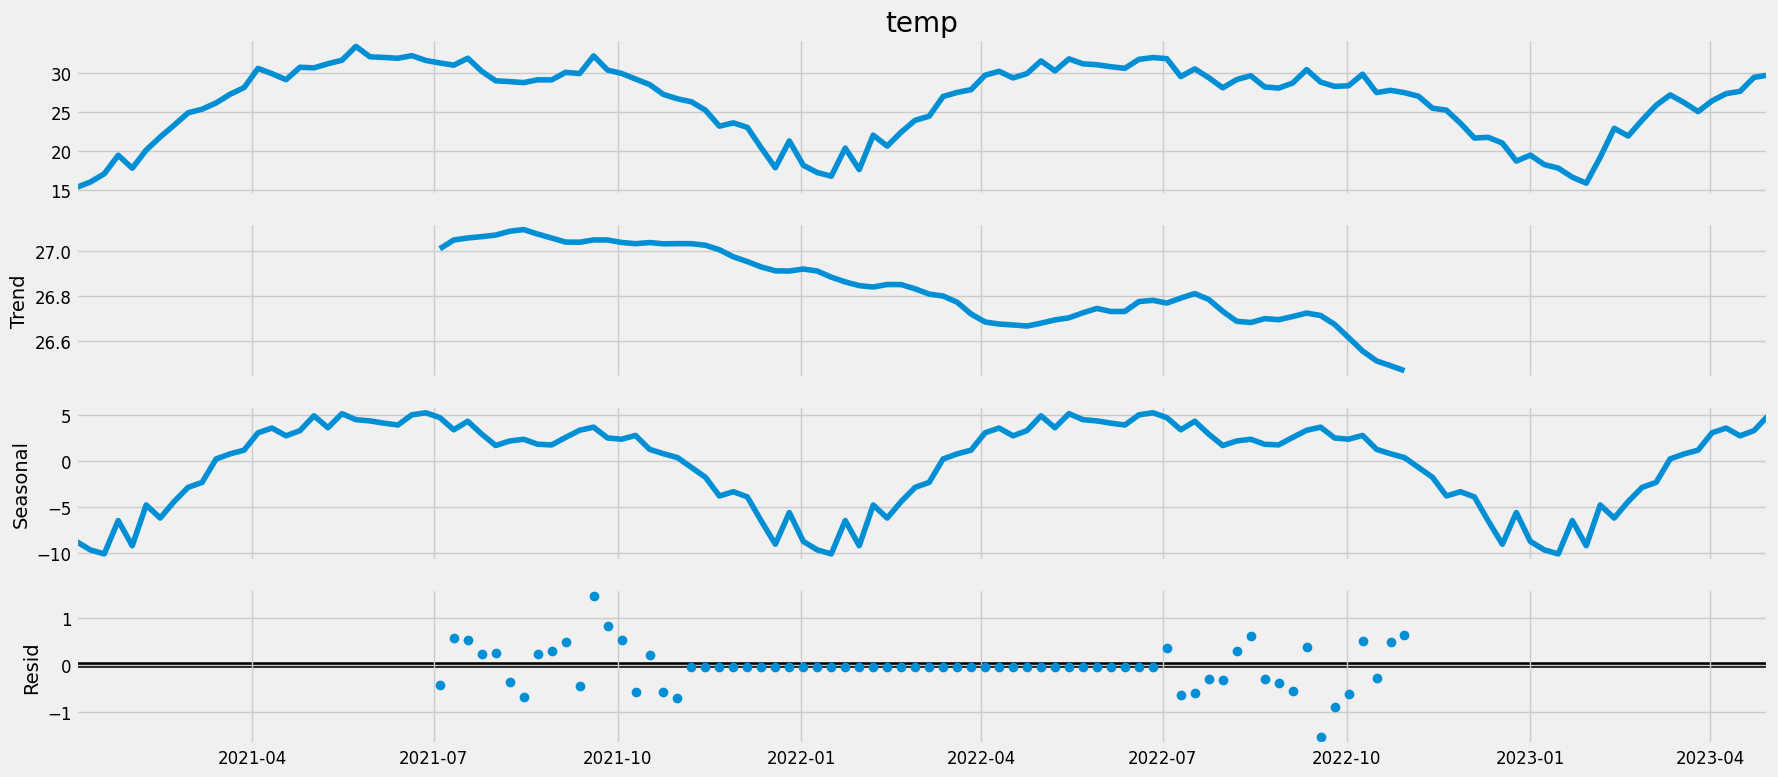

In [109]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()


As the trend shows that the value of bitcoin is increasing with proper prograganda integerated with the seasonal 
trend. The residual stills shows that there are some erros but analyzing it closely we can see that most of the values lies close to 0 which means the error is neglible. There are also not much residuals so it means that we can work on this data and can predict the weather update of Karachi.

### Q3

Split the data into training and testing sets

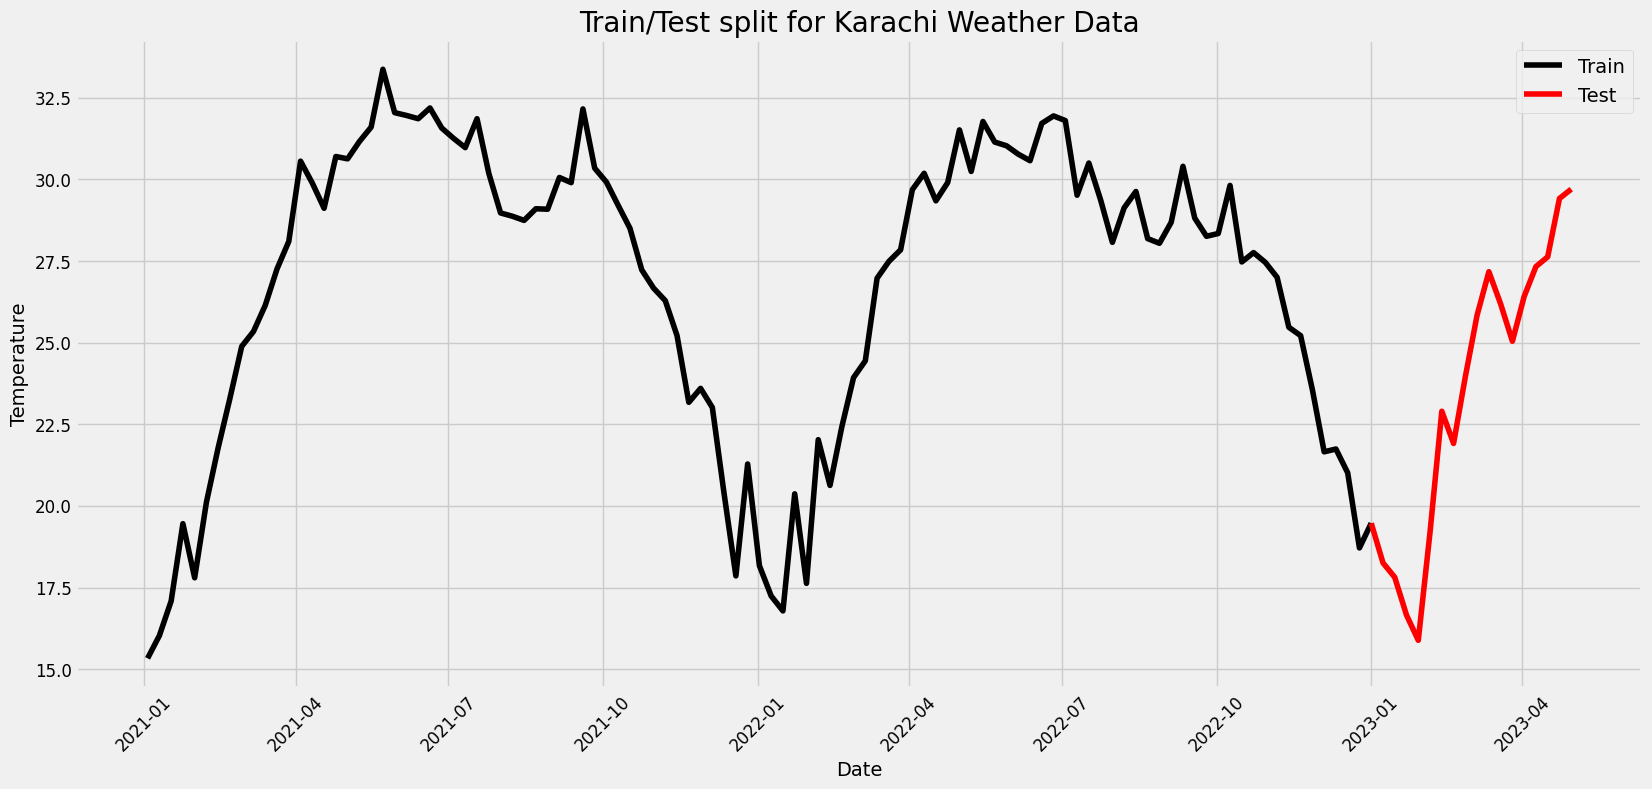

In [110]:
trainData = df[df.index <= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
testData = df[df.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(trainData, color="black", label='Train')
plt.plot(testData, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Karachi Weather Data")
plt.legend()
plt.show()



### Q4

ARIMA model

In [111]:
def ArimaModel_best(p, d, q):
    ArimaModel = ARIMA(trainData, order=(p, d, q))
    ArimaModel = ArimaModel.fit()

    yPred = ArimaModel.get_forecast(len(testData.index))

    yPred_df = yPred.conf_int(alpha=0.05)
    yPred_df['Predictions'] = ArimaModel.predict(
        start=yPred_df.index[0], end=yPred_df.index[-1])

    yPred_df.index = testData.index
    y_pred_out = yPred_df["Predictions"]

    arma_rmse = np.sqrt(mean_squared_error(testData.values, y_pred_out))
    
    return arma_rmse, y_pred_out



Best RMSE 5.0305538622418515 with combination of (2, 2, 2) 



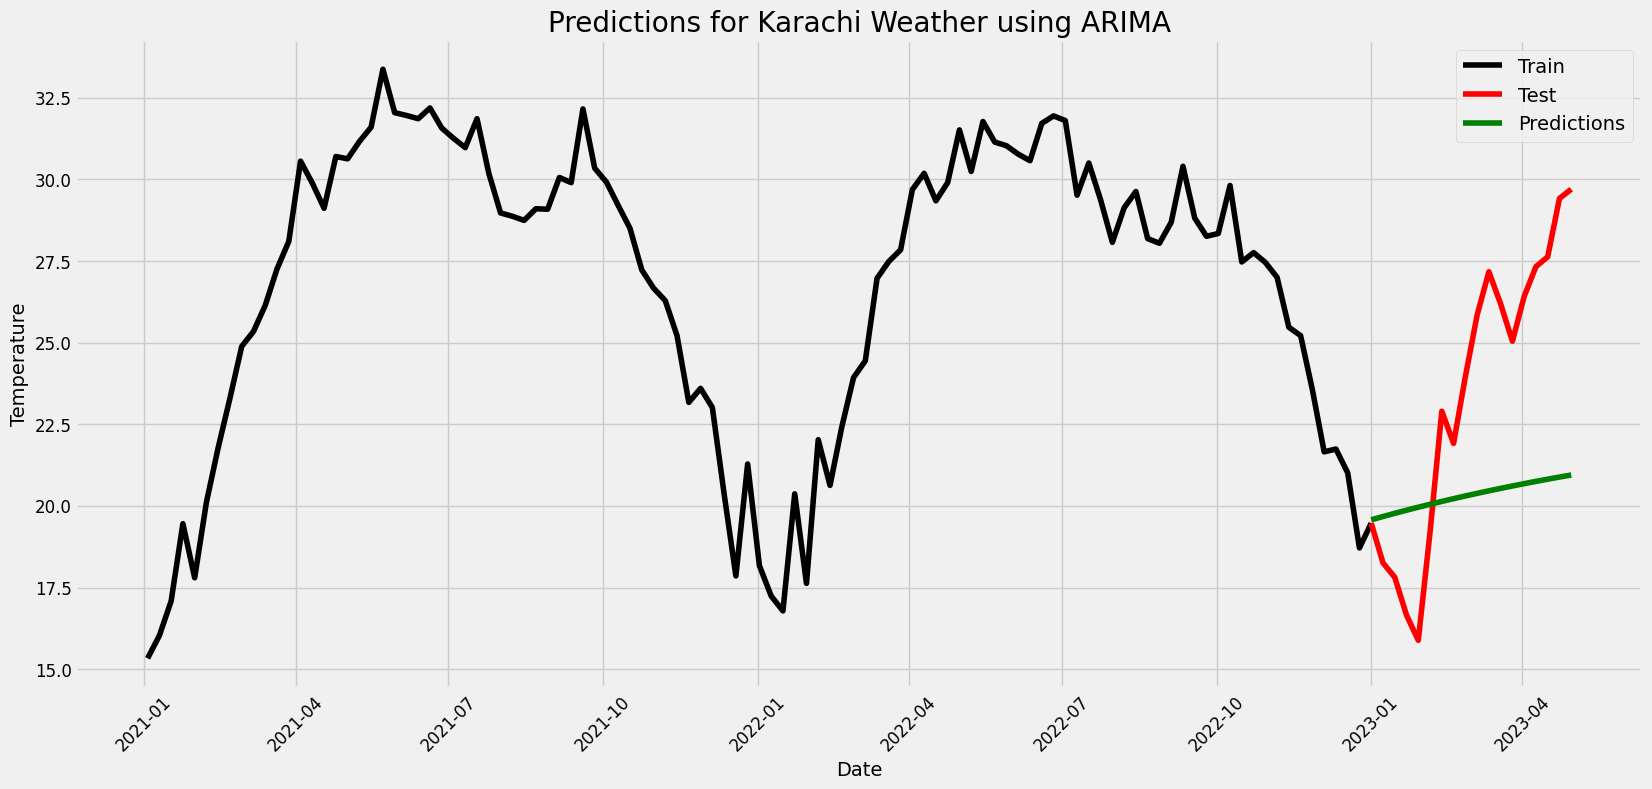

In [112]:
bestRMSE = math.inf
nums = [0, 1, 2]
combinations = list(itertools.product(nums, repeat=3))
for i in combinations:

    result = ArimaModel_best(p = i[0], d = i[1], q= i[1])
    if result[0] < bestRMSE:
        bestRMSE = result[0]
        y_pred_out = result[1]
    
print(f'Best RMSE {bestRMSE} with combination of {i} \n')

plt.plot(trainData, color="black", label='Train')
plt.plot(testData, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Weather using ARIMA")
plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

# Create a pandas dataframe with the predicted values and datetime index
df2 = pd.DataFrame({'Datetime': y_pred_out.index, 'Predicted_Temperature': y_pred_out.values,'Algorithm': 'ARIMAX'})
# Convert the Datetime column to a datetime object
# df2['Datetime'] = pd.to_datetime(df2['Datetime']).dt.strftime('%Y-%m-%d')

# Save the dataframe to a new CSV file
# df2.to_csv('predicted_temperatures.csv', index=False)

The RMSE for this model is 3.07 and the Predicted results are pretty accurate to the actual results. The graph shows that the predicted values are very close to the actual values. The model is pretty accurate and can be used to predict the weather of Karachi.

### Q5

SARIMA model

In [113]:
def bestSARIMA(orderList, seasonalOrder):
    SARIMAXmodel = SARIMAX(trainData, order = orderList, seasonal_order = seasonalOrder)
    SARIMAXmodel = SARIMAXmodel.fit()
    y_pred = SARIMAXmodel.get_forecast(len(testData.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = testData.index
    y_pred_out = y_pred_df["Predictions"]
    arma_rmse = np.sqrt(mean_squared_error(testData.values, y_pred_out))
    return arma_rmse, y_pred_out

In [114]:
n = [0, 1]
orderList = list(itertools.product(n, repeat=3))
seasonalList = list(itertools.product(n, repeat=3))
for i in range(len(seasonalList)):
  seasonalList[i] = (seasonalList[i][0], seasonalList[i][1], seasonalList[i][2], 52)
RMSE = float('inf')
for i in range(len(orderList)):
    result = bestSARIMA(orderList[i], seasonalList[i])
    if result[0] < RMSE:
        RMSE = result[0]
        y_pred_out = result[1]
        
print(f'Best RMSE {RMSE} with order = {orderList[i]} and seasonalOrder = {seasonalList[i]} \n')


Best RMSE 2.3068696926086876 with order = (1, 1, 1) and seasonalOrder = (1, 1, 1, 52) 



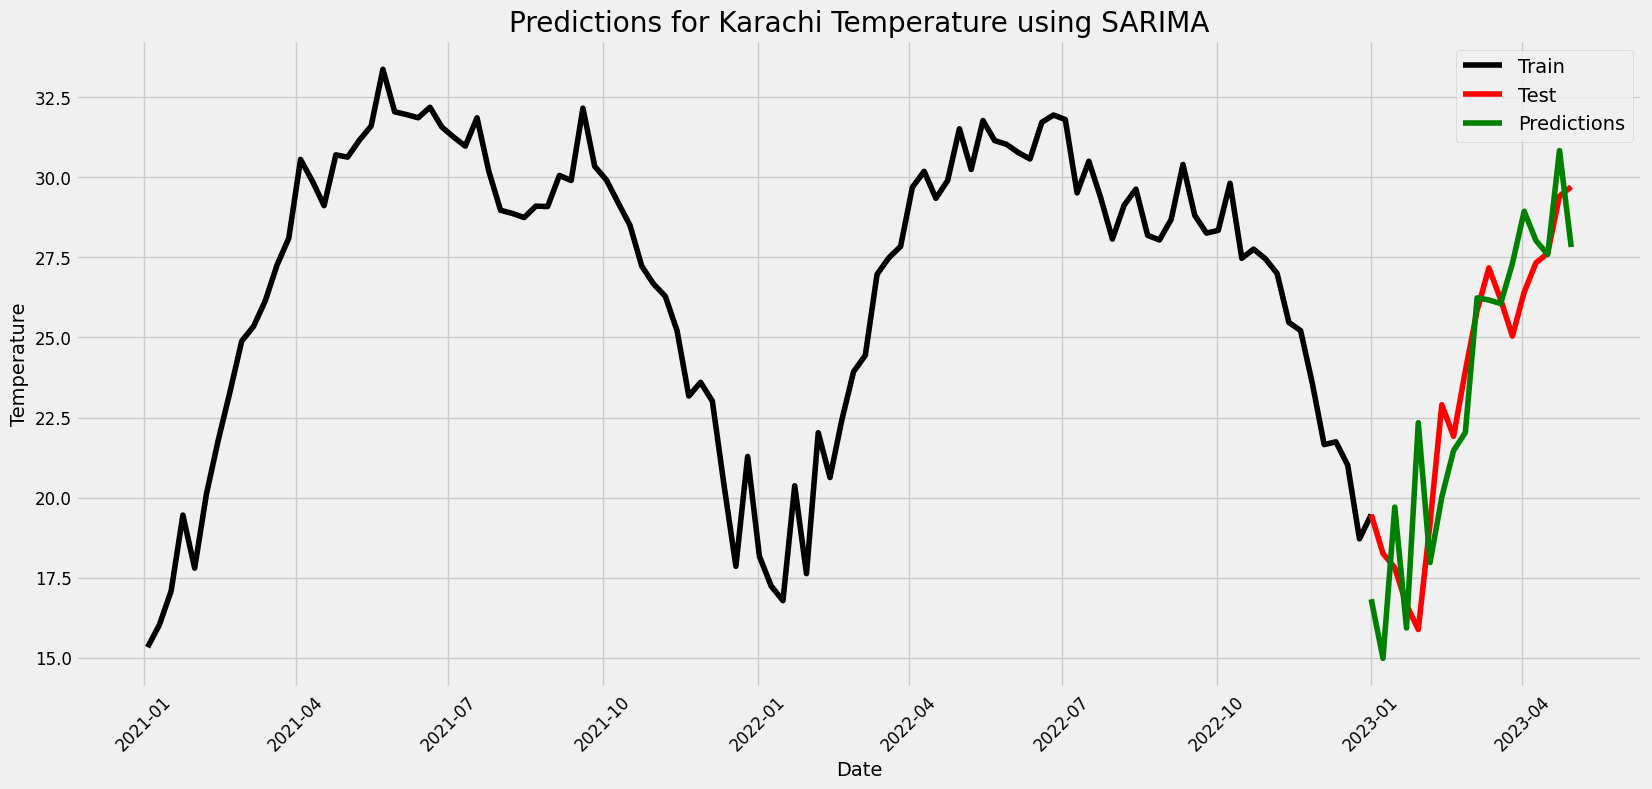

In [115]:
plt.plot(trainData, color="black", label='Train')
plt.plot(testData, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Temperature using SARIMA")
plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

### Q6

Optimize the model

In [116]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainData,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:984.8420684895568
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:494.7744164276224
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:172.65649630216632
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:178.74279486497463
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:172.4348483434874
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:-16.21189096721141
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:849.1082414922065
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:422.94360619074536
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:171.25382044879393
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:180.93695674612025
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:171.05959681377476
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:-16.08065186687442
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:367.56405761422843
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:187.7330824803878
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:201.2580770419524
AR

RMSE = 2.6211100081168555


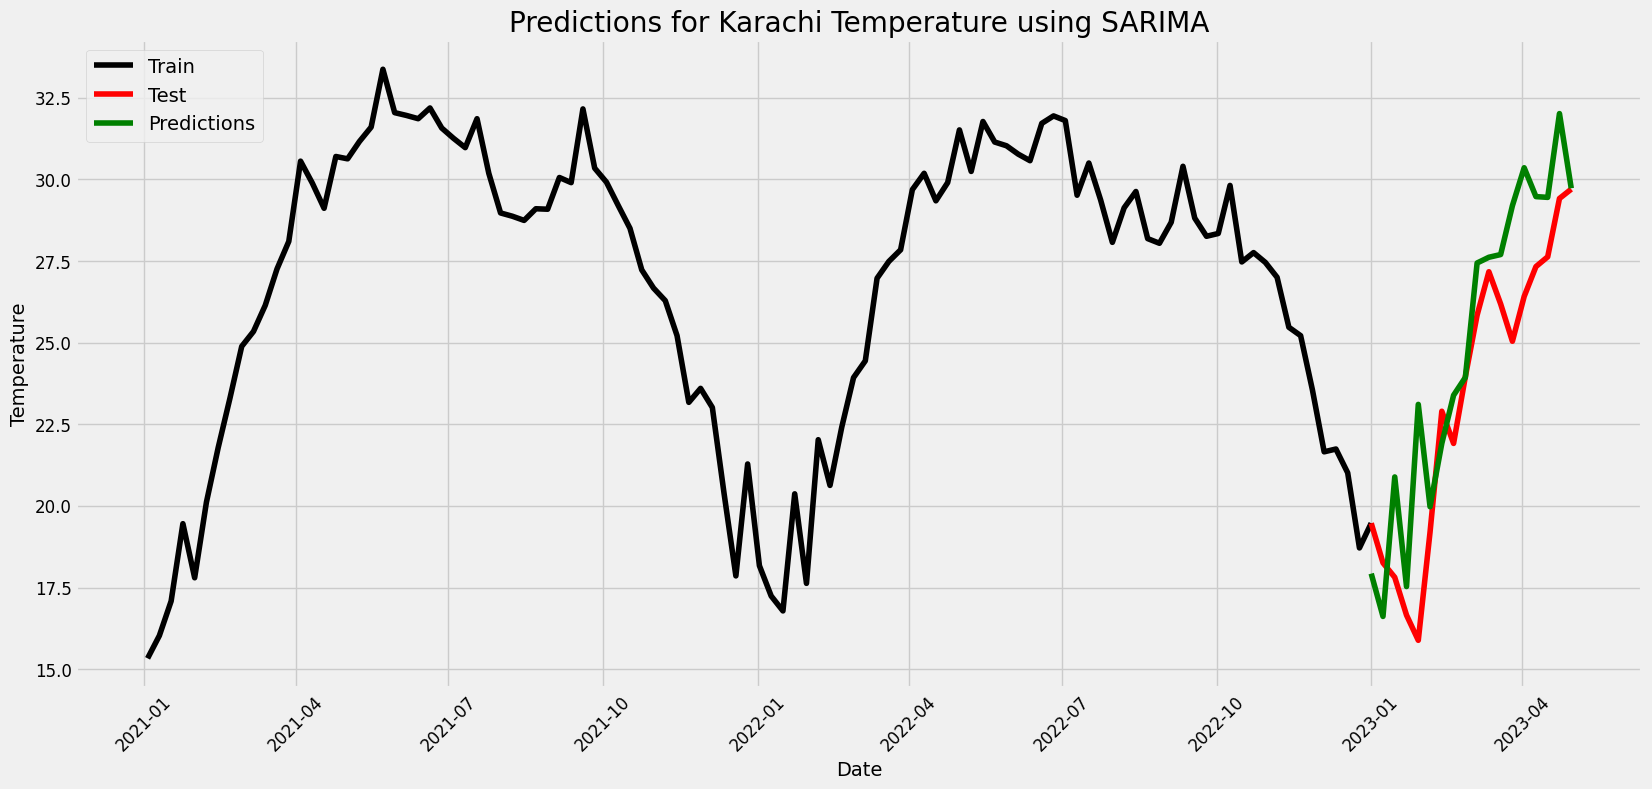

In [117]:
result = bestSARIMA((0,0,0), (1,1,0,52))
RMSE = result[0]
y_pred_out = result[1]
print(f'RMSE = {RMSE}')
plt.plot(trainData, color="black", label='Train')
plt.plot(testData, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Temperature using SARIMA")
plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

### Q7

Machine Learning Models

In [120]:
month = [x.month for x in trainData.index]
year = [x.year for x in trainData.index]
day = [x.day for x in trainData.index]
X = np.array([day, month, year]).T
Y = trainData.values
testMonth = [x.month for x in testData.index]
testYear = [x.year for x in testData.index]
testDay = [x.day for x in testData.index]
testX = np.array([testDay, testMonth, testYear]).T
testY = testData.values

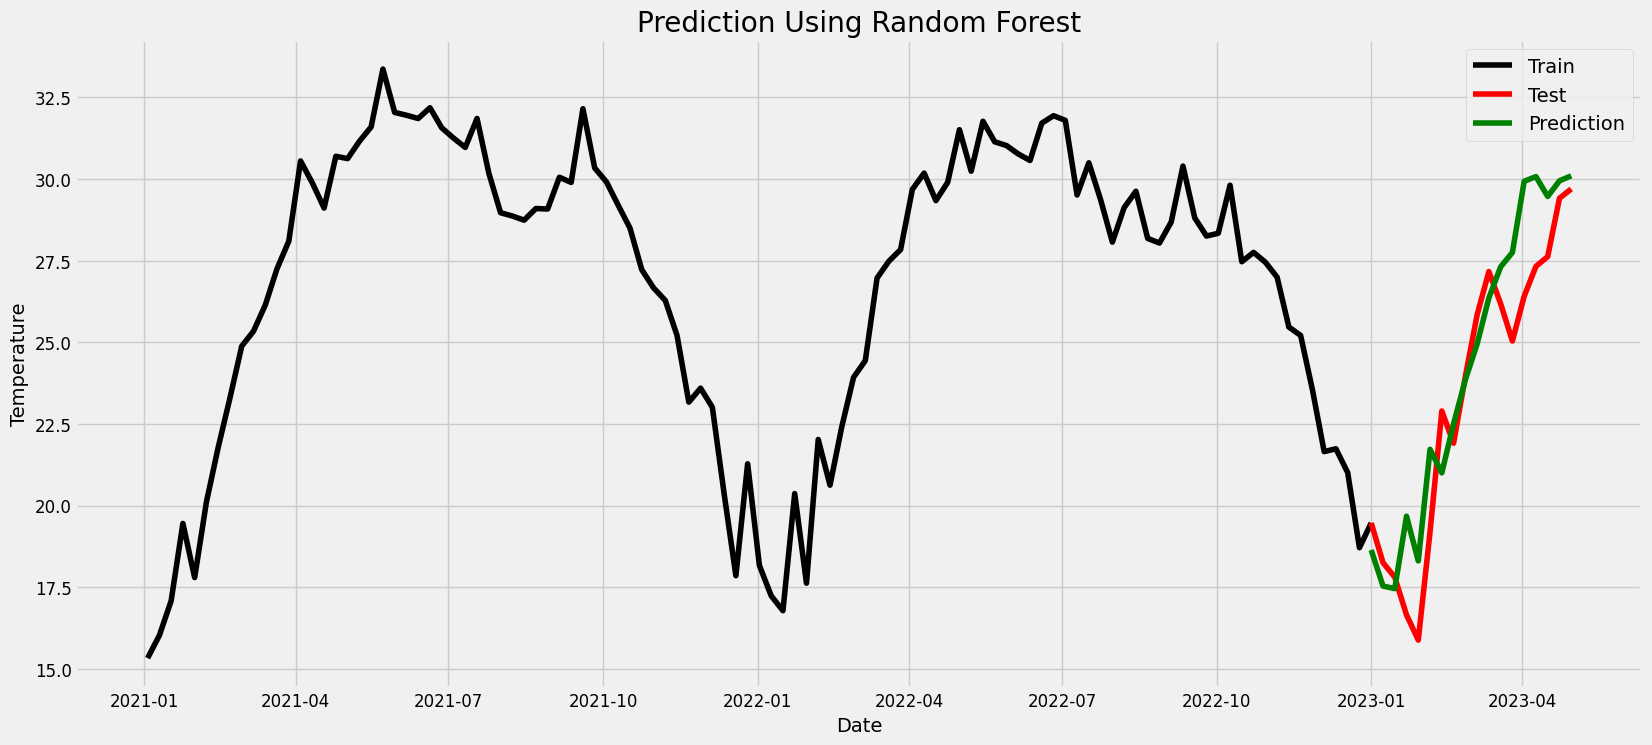

RMSE = 1.8336748042812594


In [121]:
rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)
prediction = rfmodel.predict(testX)
plt.plot(trainData.index, trainData.values,color="black", label='Train')
plt.plot(testData.index, testData.values,color="red", label='Test')
plt.plot(testData.index, prediction, color="green",label='Prediction')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Prediction Using Random Forest")
plt.show()
rmse = np.sqrt(mean_squared_error(testData.values, prediction))
print(f'RMSE = {rmse}')

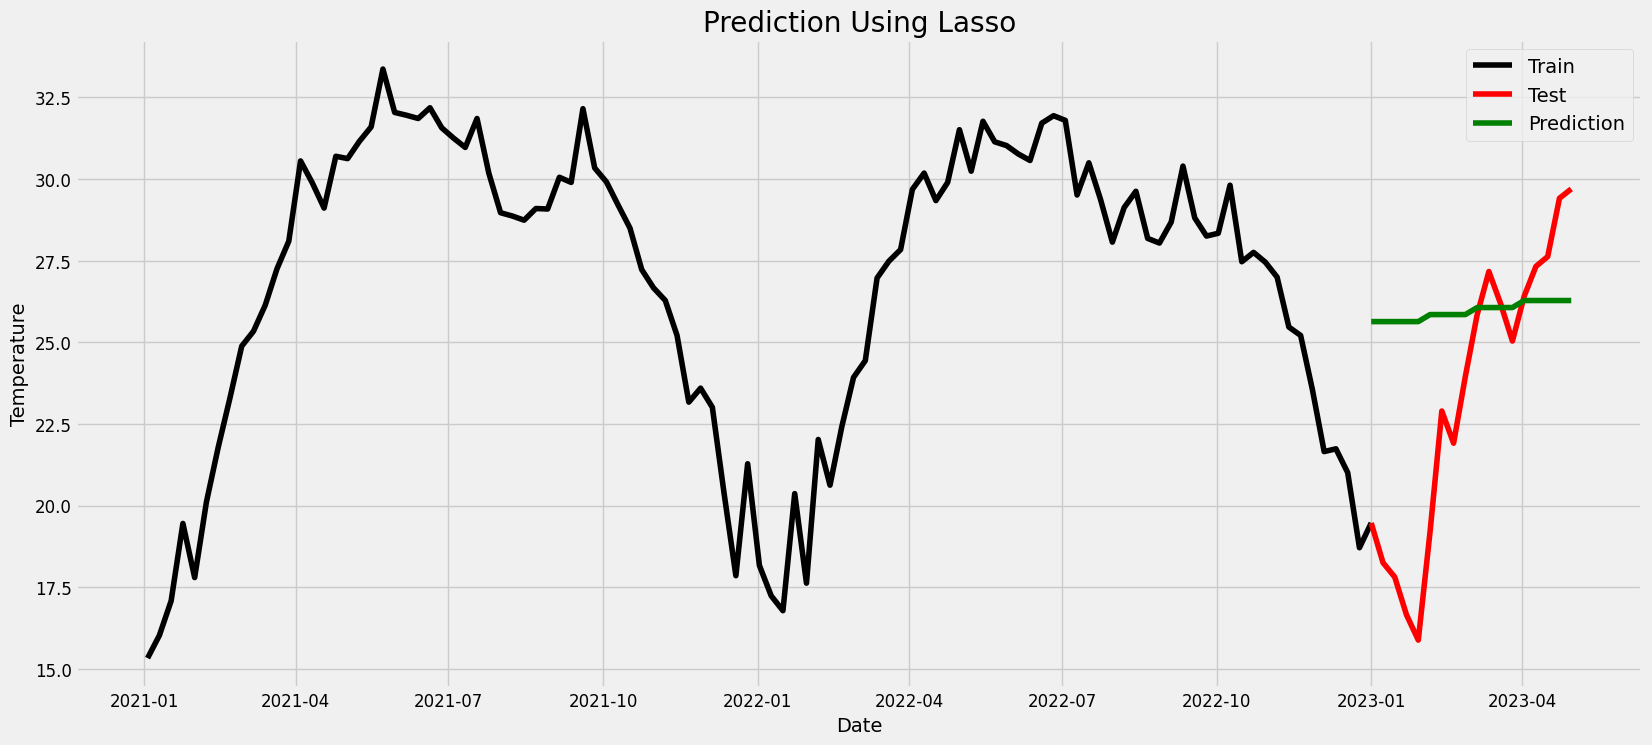

RMSE = 4.878043883878313


In [122]:
lassoModel = Lasso(alpha=1)
lassoModel.fit(X ,Y)
prediction = lassoModel.predict(testX)
plt.plot(trainData.index, trainData.values,color="black", label='Train')
plt.plot(testData.index, testData.values,color="red", label='Test')
plt.plot(testData.index, prediction, color="green",label='Prediction')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Prediction Using Lasso")
plt.show()
rmse = np.sqrt(mean_squared_error(testData.values, prediction))
print(f'RMSE = {rmse}')

### Q8

Comparison of models

The RMSE analysis reveals Random Forest regression as the most precise model, with the lowest error. While SARIMA effectively captures time-based trends and seasonality, Random Forest and Lasso Regression, being machine learning models, excel in detecting non-linear relationships. Despite their potential, SARIMA falls short against Random Forest by a small margin. Model performance hinges on correct parameter tuning, like choosing ARIMA's p, q, and d values, or setting Lasso's alpha. As an ensemble method combining multiple decision trees, Random Forest stands out as the top prediction model in this comparison.

### Q9

Generate predictions using SARIMA

In [123]:
future = pd.date_range(start='04/01/2023', end='12/31/2023', freq='W')
trainData = df[df.index < pd.to_datetime("2023-04-01", format='%Y-%m-%d')]
SARIMAXmodel = SARIMAX(trainData, order=(0, 0, 0), seasonal_order=(1, 1, 0, 52))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(steps = len(future))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = y_pred.predicted_mean
y_pred_df["Predictions"]

2023-04-02    29.843493
2023-04-09    30.131397
2023-04-16    29.301473
2023-04-23    30.044846
2023-04-30    31.353921
2023-05-07    30.408395
2023-05-14    31.740390
2023-05-21    31.546356
2023-05-28    31.212215
2023-06-04    30.986111
2023-06-11    30.804216
2023-06-18    31.799641
2023-06-25    31.875607
2023-07-02    31.701712
2023-07-09    29.778112
2023-07-16    30.745720
2023-07-23    29.518861
2023-07-30    28.234380
2023-08-06    29.082014
2023-08-13    29.468207
2023-08-20    28.351252
2023-08-27    28.231674
2023-09-03    28.934021
2023-09-10    30.309471
2023-09-17    29.419534
2023-09-24    28.634776
2023-10-01    28.627375
2023-10-08    29.703065
2023-10-15    27.657659
2023-10-22    27.661441
2023-10-29    27.314884
2023-11-05    26.870674
2023-11-12    25.424871
2023-11-19    24.844412
2023-11-26    23.564902
2023-12-03    21.902863
2023-12-10    21.494550
2023-12-17    20.442663
2023-12-24    19.179861
2023-12-31    19.236054
Freq: W-SUN, Name: Predictions, dtype: f

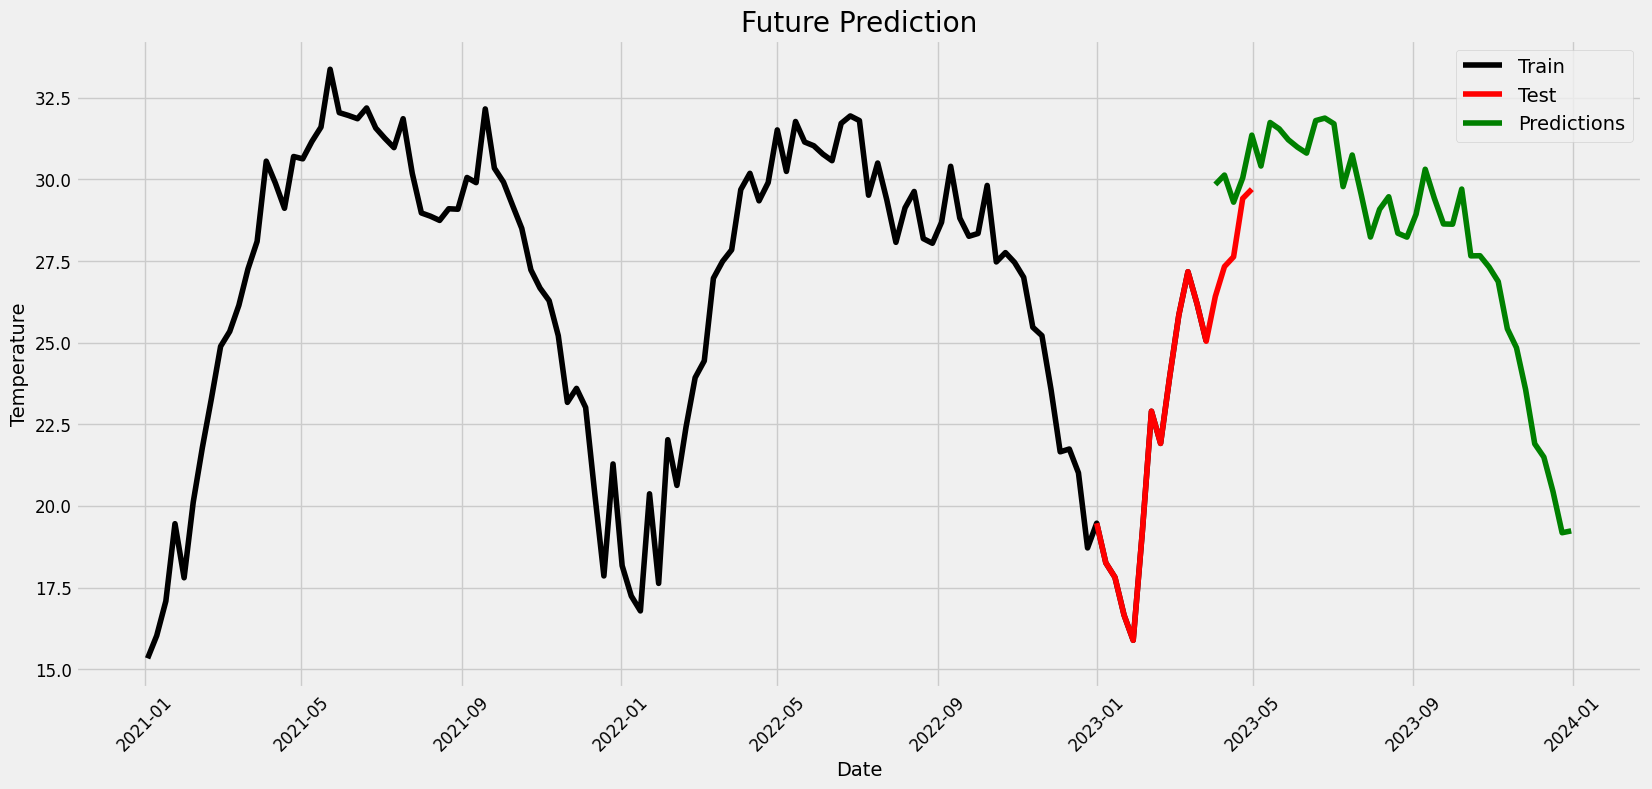

In [124]:
plt.plot(trainData, color="black", label='Train')
plt.plot(testData, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Future Prediction")
plt.plot(y_pred_df['Predictions'], color='green', label='Predictions')
plt.legend()
plt.show()

### Q10

Generate predictions using a Machine Learning model

In [125]:
month = [x.month for x in trainData.index]
year = [x.year for x in trainData.index]
day = [x.day for x in trainData.index]
X = np.array([day, month, year]).T
Y = trainData.values

future_df = pd.DataFrame(index = future)

testMonth = [x.month for x in future_df.index]
testYear = [x.year for x in future_df.index]
testDay = [x.day for x in future_df.index]

testX = np.array([testDay, testMonth, testYear]).T
testY = future_df.values

rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)
prediction = rfmodel.predict(testX)
future_df["Prediction"] = prediction
future_df

,Prediction
2023-04-02,29.933857
2023-04-09,30.072286
2023-04-16,29.530000
2023-04-23,30.071286
2023-04-30,30.221286
2023-05-07,30.721286
2023-05-14,31.455143
2023-05-21,31.519000
2023-05-28,31.257000
2023-06-04,31.009857


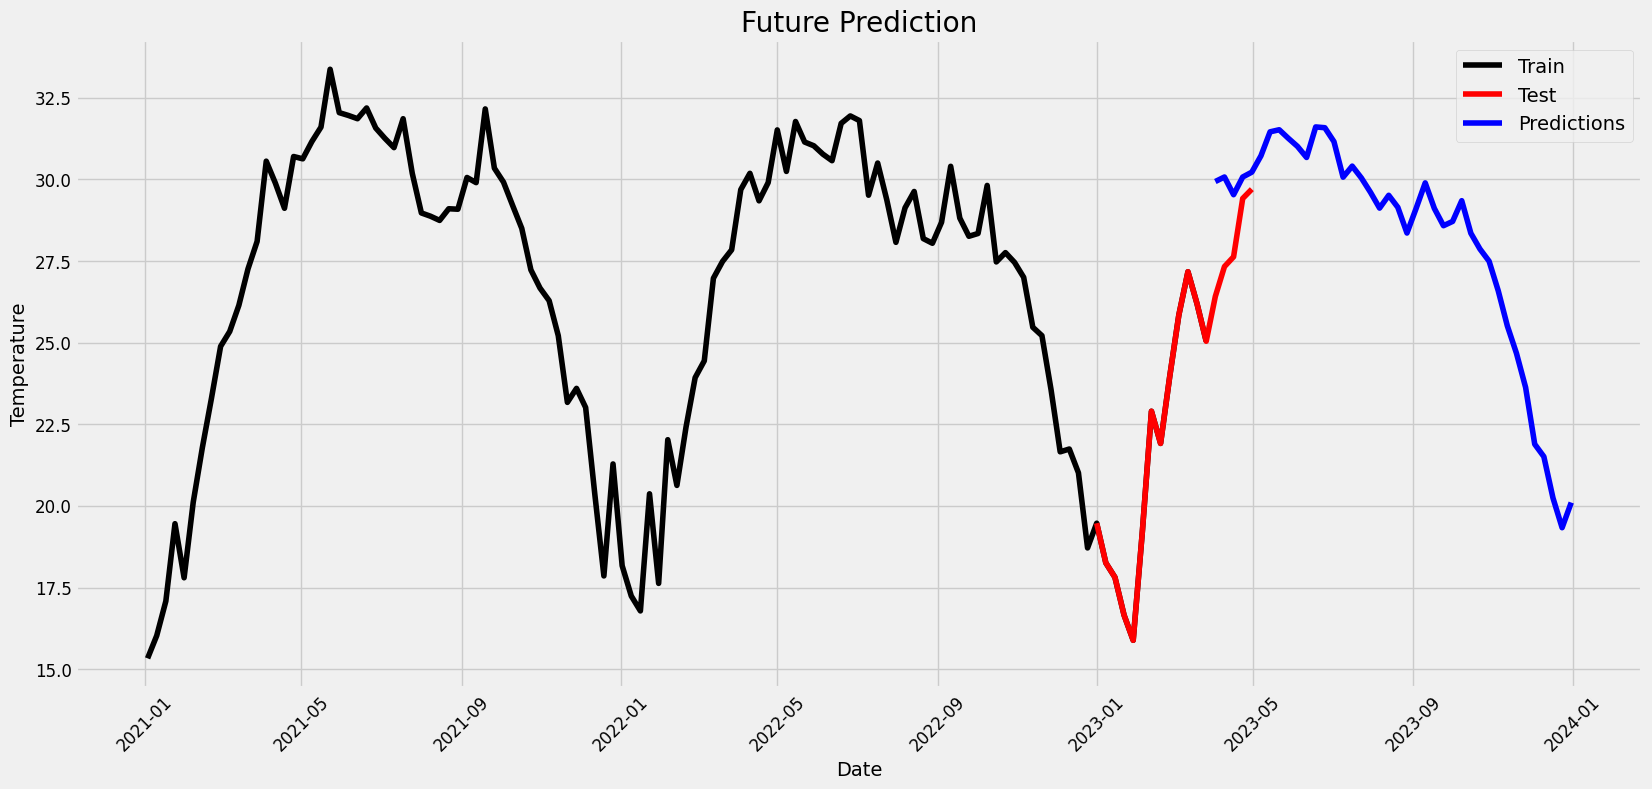

In [129]:
plt.plot(trainData, color="black", label='Train')
plt.plot(testData, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Future Prediction")
plt.plot(future_df, color='blue', label='Predictions')
plt.legend()
plt.show()

### Q11

Discuss the results from Q9 and Q10

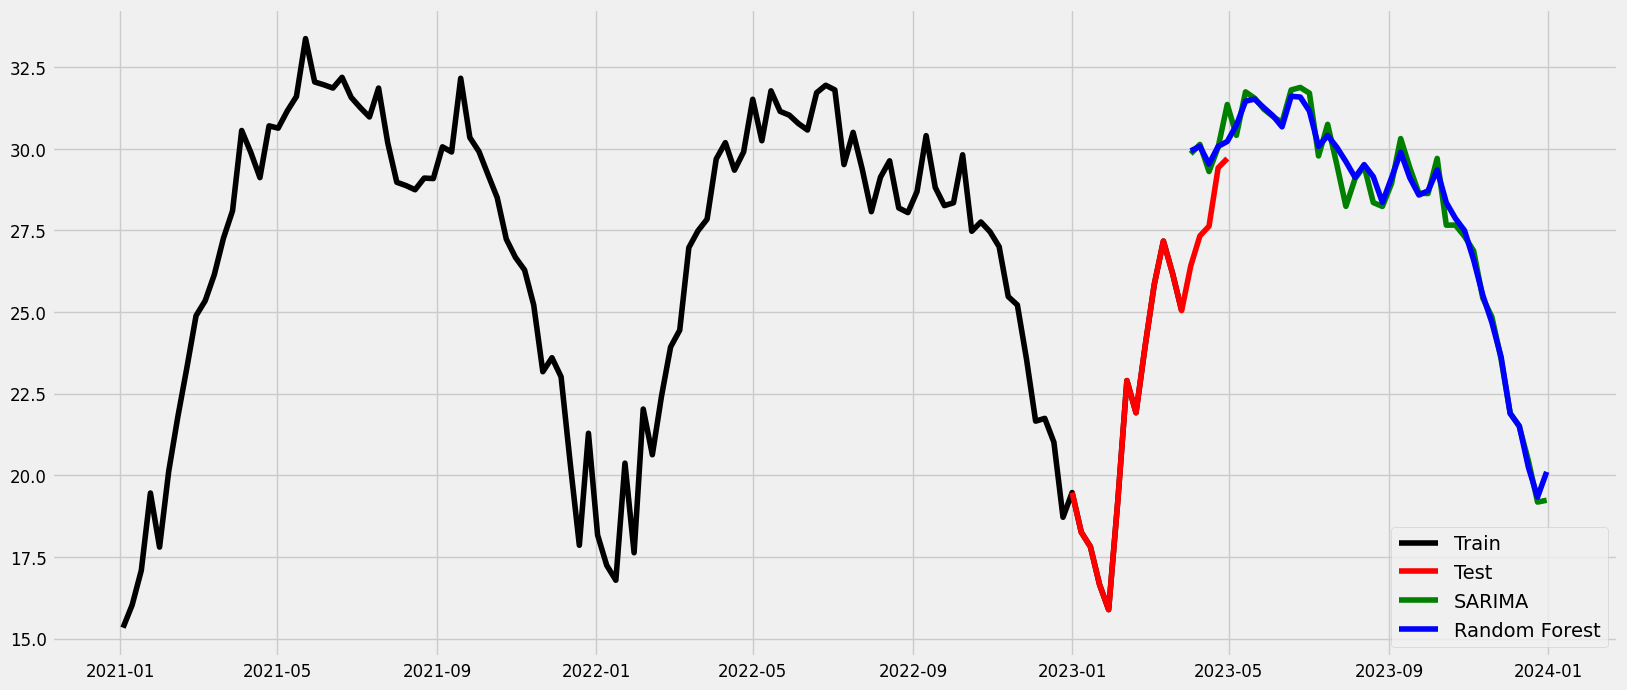

In [132]:
plt.plot(trainData.index, trainData.values,color="black", label='Train')
plt.plot(testData.index, testData.values, color="red", label='Test')
plt.plot(y_pred_df.index, y_pred_df["Predictions"],color="green", label='SARIMA')
plt.plot(future_df.index, prediction, color="blue",label='Random Forest')
plt.legend()
plt.show()

The results from SARIMA and Random Forest are pretty close to each other. However, the Random Forest model has less jitters as compared to SARIMA which is one notable difference.